In [2]:
# Brian Kao's  Code used for Data Analysis for  Apple Case Study



import numpy as np
import pandas as pd
from numpy import genfromtxt
import requests, zipfile, io
import matplotlib.pyplot as plt
!pip install surprise
import surprise
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader
import time
import datetime as dt
import seaborn as sns

from google.colab import files


r = requests.get('https://s3.us-east-2.amazonaws.com/rudydata/sf-police-calls-for-service-and-incidents.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

calls= 'police-department-calls-for-service.csv'
calls = pd.read_csv(calls)
nRow , nCol = calls.shape
print(f'There are {nRow} rows and {nCol} columns for Calls Table')

incidents= 'police-department-incidents.csv'
incidents = pd.read_csv(incidents)
nRow1 , nCol1 = incidents.shape

print(f'There are {nRow1} rows and {nCol1} columns for Incidents table')

     |████████████████████████████████| 3.3MB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise
There are 2277316 rows and 14 columns for Calls Table
There are 2215024 rows and 33 columns for Incidents table


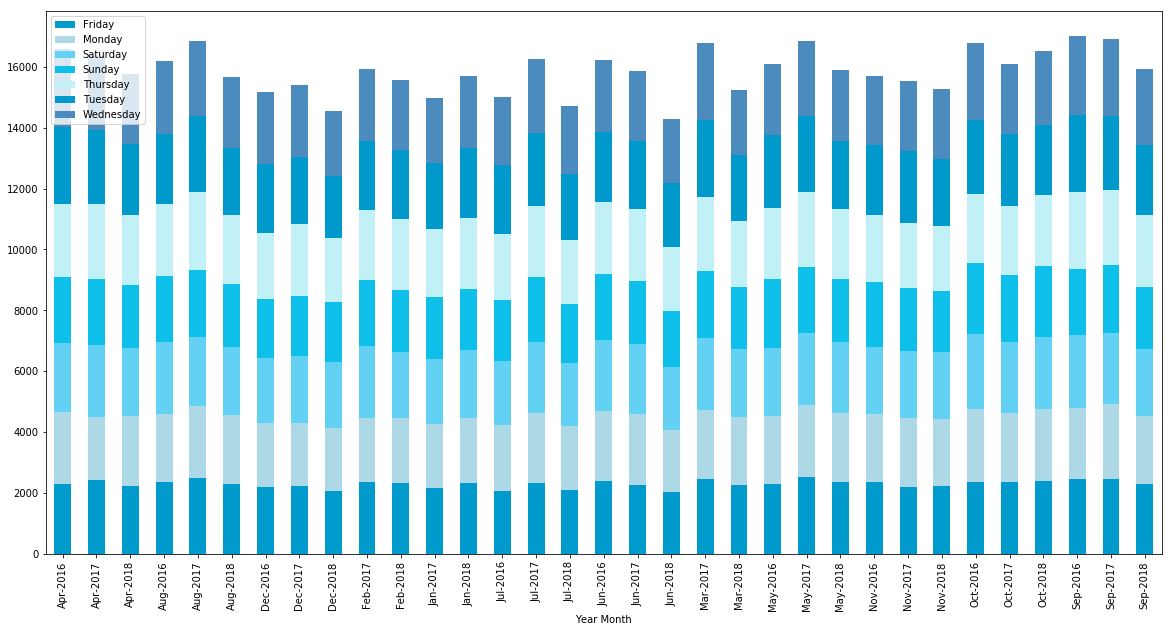

In [3]:
# Call Data and Graphs
calls.columns
calls.head(2)


calls['Call Date'] = pd.to_datetime(calls['Call Date'])

calls['Call Date Time'] = pd.to_datetime(calls['Call Date Time'])
calls['Year Month'] = calls['Call Date'].apply(lambda x: dt.datetime.strftime(x,'%y-%b'))
calls['Weekday'] = calls['Call Date'].apply(lambda x: dt.datetime.strftime(x, '%A'))
calls['Year Month'] = calls['Call Date'].apply(lambda x: dt.datetime.strftime(x,'%b-%Y'))
calls['Year'] = calls['Call Date'].apply(lambda x: dt.datetime.strftime(x,'%Y'))
calls['Hour'] = calls['Call Date Time'].apply(lambda x: dt.datetime.strftime(x, '%H'))
calls['Weekday'].unique()

calls.head()

df5 = calls.loc[calls['Year Month'] != 'Mar-2016']
df5  = df5.groupby(['Year Month','Call Date', 'Weekday']).count() 
df5.index.values
df5 = df5.groupby(['Year Month', 'Weekday']).mean()
df5
df5.reset_index(level=0, inplace=True)
df5.reset_index(level=0, inplace=True)

df5

#df_h2 = df_gb4.pivot_table(values = 'IncidntNum', index = ['Year Month'], columns = 'Weekday', aggfunc=np.sum )
 

df5['Year Month'].unique()
fig, ax = plt.subplots(figsize=(20,10))  

Days = df5['Weekday'].drop_duplicates()
margin_bottom = np.zeros(len(df5['Year Month'].drop_duplicates()))
margin_bottom
colors = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC',  '#4B8BBE']

for num, day in enumerate(Days):
    values = list(df5[df5['Weekday'] == day].loc[:, 'Crime Id'])
    #print (day)
    #print(values)
    df5[df5['Weekday'] == day].plot.bar(x='Year Month',y='Crime Id', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=colors[num], label=day)
    margin_bottom += values

plt.show()


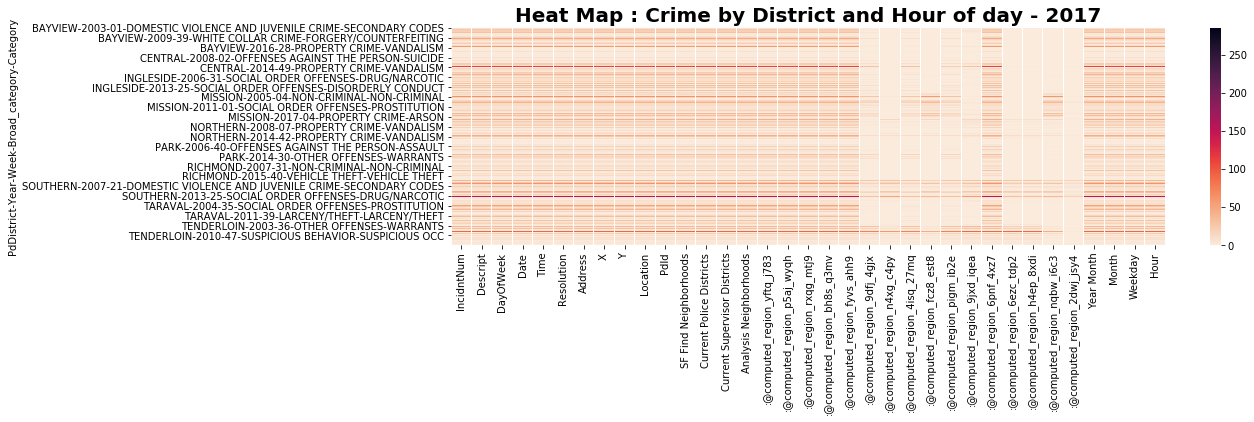

In [7]:
#Preparing Incidents data
incidents.columns
incidents.head(2)

# Categorizing Incidents Data into Broader Categories
def rename_categories(input_val):
    if input_val in ['SEX OFFENSES, FORCIBLE','SEX OFFENSES, NON FORCIBLE','ROBBERY',
                     'ASSAULT','KIDNAPPING','SUICIDE','EXTORTION','BRIBERY','MISSING PERSON']:
        return 'OFFENSES AGAINST THE PERSON'
    elif input_val in ['BAD CHECKS','EMBEZZLEMENT','FORGERY/COUNTERFEITING','FRAUD']:
        return 'WHITE COLLAR CRIME'
#     elif input_val in ['LARCENY/THEFT','VEHICLE THEFT']:
#         return 'THEFT'
    elif input_val in ['BURGLARY','ARSON','VANDALISM','STOLEN PROPERTY','TRESPASS']:
        return 'PROPERTY CRIME'
    elif input_val in ['DRUG/NARCOTIC','PROSTITUTION','GAMBLING','PORNOGRAPHY/OBSCENE MAT',
                       'DISORDERLY CONDUCT','DRUNKENNESS','DRIVING UNDER THE INFLUENCE',
                       'LIQUOR LAWS']:
        return 'SOCIAL ORDER OFFENSES'
    elif input_val == 'SECONDARY CODES':
        return 'DOMESTIC VIOLENCE AND JUVENILE CRIME'
    elif input_val in ['SUSPICIOUS OCC','LOITERING','TREA']:
        return 'SUSPICIOUS BEHAVIOR'
    elif input_val in ['RUNAWAY','FAMILY OFFENSES','RECOVERED VEHICLE','WEAPON LAWS',
                       'WARRANTS']:
        return 'OTHER OFFENSES'
    else:
        return input_val


incidents['Broad_category'] = incidents['Category'].apply(rename_categories)
incidents['Date'] = pd.to_datetime(incidents['Date'])
incidents['Week'] = incidents['Date'].apply(lambda x: dt.datetime.strftime(x,'%V'))
incidents['Time'] = pd.to_datetime(incidents['Time'])
incidents['Year Month'] = incidents['Date'].apply(lambda x: dt.datetime.strftime(x,'%b-%Y'))
incidents['Month'] = incidents['Date'].apply(lambda x: dt.datetime.strftime(x,'%b'))
incidents_m = incidents['IncidntNum']
incidents_m.head()
incidents['Weekday'] = incidents['Date'].apply(lambda x: dt.datetime.strftime(x, '%A'))
incidents['Hour'] = incidents['Time'].apply(lambda x: dt.datetime.strftime(x, '%H'))
incidents['Year'] = incidents['Date'].apply(lambda x: dt.datetime.strftime(x,'%Y'))
incidents.head()
nrows, ncol = incidents.shape
print(nrows)
joined = calls.merge ( incidents_m, left_on = 'Crime Id' , right_on = 'IncidntNum' )
nRow1 , nCol1 = joined.shape
print(f'There are {nRow1} rows and {nCol1} columns for Incidents table')

#download Incidents by Year, Month, Category, Hour, Weekday
dfi  = incidents.groupby(['Year Month','Broad_category', 'Category', 'Weekday', 'Hour']).count() 

dfi_pivot= dfi.pivot_table(values = 'IncidntNum', index = ['Year Month','Category','Hour'], columns = 'Weekday', aggfunc=np.sum )

dfi_pivot.to_csv('dfi.csv')
files.download('dfi.csv')


#download Incidents by Year, Month,  Hour, Weekday
dfi  = incidents.groupby(['Year Month','Broad_category', 'Category', 'Weekday', 'Hour']).count() 

dfi_pivot= dfi.pivot_table(values = 'IncidntNum', index = ['Year Month','Category','Hour'], columns = 'Weekday', aggfunc=np.sum )

dfi_pivot.to_csv('dfi.csv')
files.download('dfi.csv')

#download Incidents by District, Year, Week, Category, BroadCategory

dfi  = incidents.groupby(['PdDistrict', 'Year', 'Week','Broad_category', 'Category']).count() 
dfi_pivot =  dfi.pivot_table(values = 'IncidntNum', index =  ['PdDistrict', 'Year', 'Week','Category'], columns = 'Broad_category', aggfunc=np.sum )

dfi_pivot.to_csv('dfi.csv')
files.download('dfi.csv')

# Heatmap 

fig, ax = plt.subplots()
fig.set_size_inches(16, 4)
ax = sns.heatmap(dfi, ax=ax, cmap= sns.cm.rocket_r, color = 'Blue')
plt.title('Heat Map : Crime by District and Hour of day - 2017', fontsize=20, weight='bold')

plt.show()


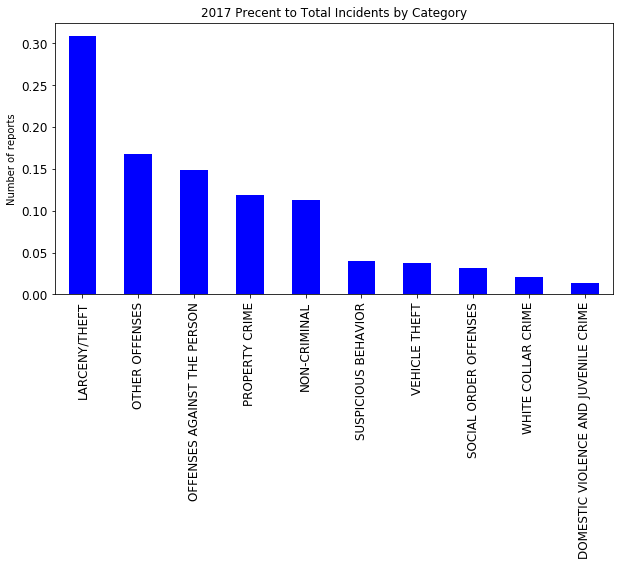

In [15]:
# --- Imports ---
import sys,os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

incidents['Broad_category'] = incidents['Category'].apply(rename_categories)
incidents['Date'] = pd.to_datetime(incidents['Date'])
incidents['Week'] = incidents['Date'].apply(lambda x: dt.datetime.strftime(x,'%V'))
incidents['Time'] = pd.to_datetime(incidents['Time'])
incidents['Year Month'] = incidents['Date'].apply(lambda x: dt.datetime.strftime(x,'%b-%Y'))
incidents['Month'] = incidents['Date'].apply(lambda x: dt.datetime.strftime(x,'%b'))
incidents_m = incidents['IncidntNum']
incidents_m.head()
incidents['Weekday'] = incidents['Date'].apply(lambda x: dt.datetime.strftime(x, '%A'))
incidents['Hour'] = incidents['Time'].apply(lambda x: dt.datetime.strftime(x, '%H'))
incidents['Year'] = incidents['Date'].apply(lambda x: dt.datetime.strftime(x,'%Y'))
incidents['Year'] = incidents['Date'].apply(lambda x: dt.datetime.strftime(x,'%Y'))
incidents = incidents.loc[incidents['Year'] == '2017']



def plotdat(incidents,cat):
    l = incidents[cat].value_counts(normalize = True)
    l.sort_values(inplace = True, ascending = False)
    fig=plt.figure(figsize=(10,5))
    plt.yticks(fontsize=8)
    l.plot(kind='bar',fontsize=12,color='b')
    plt.xlabel('')
    plt.ylabel('Number of reports',fontsize=10)
    plt.title('2017 Precent to Total Incidents by Category')

plotdat(incidents, 'Broad_category')







In [18]:



d_crime = incidents
def types_districts(d_crime,per):
    
    # Group by crime type and district 
    hoods_per_type=d_crime.groupby('Descript').Month.value_counts(sort=True)
    w=hoods_per_type.unstack().fillna(0)
    w
    # Sort by hood sum
    hood_sum=w.sum(axis=0)
    hood_sum.sort_values(ascending=False)
    w=w[hood_sum.index]
    w  
    # Filter by crime per district
    crime_sum=w.sum(axis=1)
    crime_sum.sort_values(ascending=False)
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    w=w.loc[ix.index]
    return w
    
w=types_districts(d_crime,90)
w

a  = ['Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday', 'Sunday']
b  = ['Jan','Feb','Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
w1 = w.reindex(columns = b)

w1

Month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Descript,,,,,,,,,,,,
AGGRAVATED ASSAULT WITH A DEADLY WEAPON,89.0,107.0,111.0,62.0,95.0,126.0,111.0,99.0,79.0,111.0,107.0,105.0
AGGRAVATED ASSAULT WITH A KNIFE,35.0,33.0,24.0,27.0,31.0,33.0,33.0,32.0,22.0,34.0,30.0,36.0
AGGRAVATED ASSAULT WITH BODILY FORCE,63.0,90.0,47.0,56.0,93.0,73.0,68.0,75.0,79.0,50.0,71.0,79.0
AIDED CASE,107.0,98.0,82.0,106.0,105.0,91.0,108.0,126.0,102.0,98.0,83.0,76.0
"AIDED CASE, MENTAL DISTURBED",358.0,397.0,339.0,375.0,370.0,346.0,385.0,417.0,373.0,326.0,329.0,380.0
BATTERY,373.0,427.0,348.0,298.0,355.0,392.0,369.0,400.0,387.0,359.0,373.0,358.0
"BATTERY, FORMER SPOUSE OR DATING RELATIONSHIP",94.0,102.0,104.0,88.0,97.0,108.0,84.0,97.0,90.0,101.0,107.0,108.0
"BURGLARY OF APARTMENT HOUSE, UNLAWFUL ENTRY",46.0,46.0,52.0,46.0,47.0,34.0,44.0,46.0,47.0,38.0,58.0,49.0
"BURGLARY OF RESIDENCE, FORCIBLE ENTRY",27.0,14.0,46.0,38.0,33.0,24.0,38.0,35.0,37.0,25.0,40.0,28.0


In [0]:
##########################
df1 = pd.cut(df1, bins = bins , labels = labels , right = False).value_counts()

df1 = read_p
df1.to_frame()

for x in data:
  data = [x[3] for x om [redo]]
  
  data = [d.]
  
  a.extend(b)

nrows, ncol = incidents.shape
print(nrows)

BINARY
Y = df[quality].values
Y = np.array([1 if y >= 6 else 0 for y in Y])

STACK
resulting_set = train_set.append(test_set)
B) resulting_set = np.concatenate([train_set, test_set])
C) resulting_set = np.vstack([train_set, test_set])

incidents['Date'] = pd.to_datetime(incidents['Date'])
incidents['Week'] = incidents['Date'].apply(lambda x: dt.datetime.strftime(x,'%V'))

for todo in todos:
    if todo["completed"]:
        try:
            # Increment the existing user's count.
            todos_by_user[todo["userId"]] += 1
        except KeyError:
            # This user has not been seen. Set their count to 1.
            todos_by_user[todo["userId"]] = 1

# Create a sorted list of (userId, num_complete) pairs.
top_users = sorted(todos_by_user.items(), 
                   key=lambda x: x[1], reverse=True)

list = [int(i) for i in list]
list.sort()

data = args


<Figure size 1080x720 with 0 Axes>

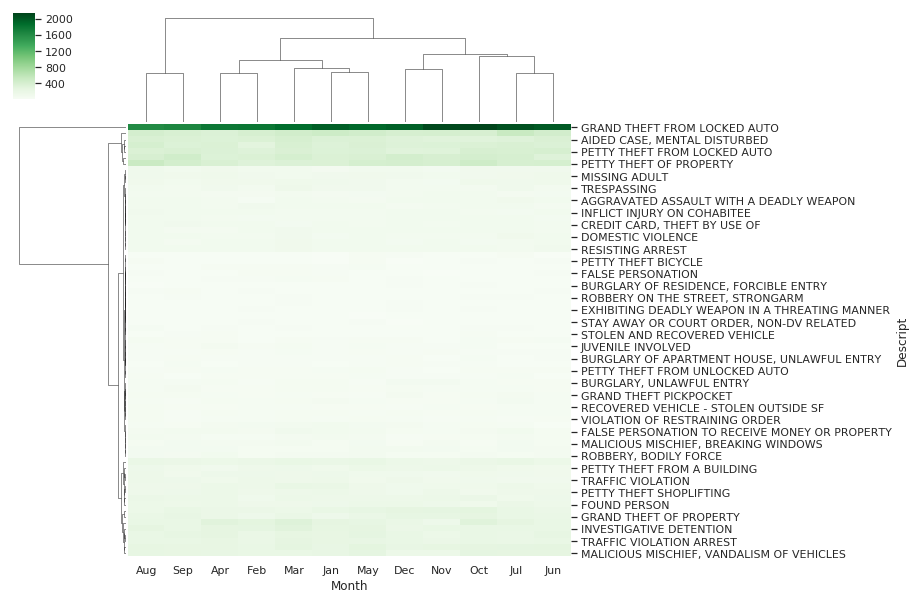

In [20]:
import seaborn as sns; sns.set(color_codes=True)
cmap = "Greens"
plt.figure(figsize=(15,10))

sns.clustermap(w, cmap = cmap) 

Crime Id  Report Date  ...  Year  Hour
Year Month Original Crime Type Name                         ...            
Apr-2016   'S                             1.0          1.0  ...   1.0   1.0
           ****Poss 221***                1.0          1.0  ...   1.0   1.0
           ***901 Req***                  1.0          1.0  ...   1.0   1.0
           ***909***                      1.0          1.0  ...   1.0   1.0
           **909**                        1.5          1.5  ...   1.5   1.5

[5 rows x 15 columns]

In [26]:

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1770916 entries, 0 to 2215023
Data columns (total 39 columns):
IncidntNum                      int64
Category                        object
Descript                        object
DayOfWeek                       object
Date                            datetime64[ns]
Time                            datetime64[ns]
PdDistrict                      float64
Resolution                      object
Address                         object
X                               float64
Y                               float64
Location                        object
PdId                            int64
SF Find Neighborhoods           float64
Current Police Districts        float64
Current Supervisor Districts    float64
Analysis Neighborhoods          float64
:@computed_region_yftq_j783     float64
:@computed_region_p5aj_wyqh     float64
:@computed_region_rxqg_mtj9     float64
:@computed_region_bh8s_q3mv     float64
:@computed_region_fyvs_ahh9     float64
:@c

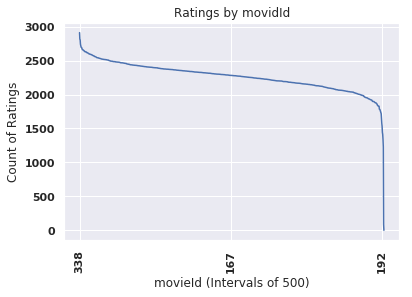

In [60]:


callsJuly = calls.loc[calls['Year Month'] == '18-Jul']

# stacked Bar for Calls by Month

df5  = calls.groupby(['Year Month','Original Crime Type Name', 'Call Date', 'Weekday']).count() 

df5 = df5.groupby(['Year Month', 'Original Crime Type Name', 'Weekday']).mean()
#df5
df5.unstack()
df5.unstack()
df5.reset_index(inplace=True)   

df5.head()

df51 = df5.pivot_table(values = 'Crime Id', index = ['Year Month', 'Original Crime Type Name' ], columns = 'Weekday', aggfunc=np.sum )
 
df51.to_csv('df.csv')
files.download('df.csv')  
  
  
  
df5  = calls.groupby(['Call Date', 'Weekday']).count() 
df5.index.values
#df5 = df5.groupby(['Year Month', 'Original Crime Type Name']).mean()
df5
df5.reset_index(inplace=True)   

  

fig, ax = plt.subplots(figsize=(40,10))  

Days = df5['Weekday'].drop_duplicates()
Days
margin_bottom = np.zeros(len(df5['Year Month'].drop_duplicates()))
margin_bottom
colors = ["#006D2C", "#31A354","#74C476","#74C476","#74C476","#74C476","#74C476"]

for num, day in enumerate(Days):
    values = list(df5[df5['Weekday'] == day].loc[:, 'Crime Id'])
    #print (day)
    #print(values)
    df5[df5['Weekday'] == day].plot.bar(x='Weekday',y='Crime Id', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=colors[num], label=day)
    margin_bottom += values

plt.show()


fig = Category_crimes_2016_df["Percentage"].plot(kind="bar", figsize = (20,10), rot=75) 

fig.set_title("Frequency of Crimes by Category - 2016", fontsize=15, weight = "bold")
fig.set_ylabel("Percentage of Crimes", fontsize=12)
plt.savefig('../plot/04.perc_crime_category_2016.png')
plt.show()


plt.show()

df5  = calls.groupby(['Weekday', 'Hour']).count() 
df5.index.values

df5
df5.describe()

df7  = callsJuly.groupby(['Weekday', 'Hour']).count()
df7

df_gb2 = df5


fig, ax = plt.subplots()
fig.set_size_inches(16, 4)
ax = sns.heatmap(df_h2, ax=ax, cmap= sns.cm.rocket_r, color = 'Blue')
plt.title('Heat Map : Crime by District and Hour of day - 2017', fontsize=20, weight='bold')



df9  = joined.groupby(['Year Month','Call Date', 'Weekday']).count() 
df9.index.values
df9 = df9.groupby(['Year Month', 'Weekday']).mean()
df9
df9.reset_index(inplace=True)
df91 = df9.pivot( 'Year Month', 'Weekday' , "IncidntNum")
df91.to_csv('df.csv')
files.download('df.csv')



totalrange.days


df10 = incidents.groupby(['Date']).count()
mindate = min(incidents['Date'])
mindate 
maxdate = max(incidents['Date'])
maxdate



df5 = df5.sort_values(['Year Month', 'Weekday'], ascending = False)
crime_count = df5['Crime Id'].values
mids = df5['Crime Id'].index.values
x = range(0,len(mids)-1, 500)

plt.xticks(x, mids)
plt.xticks(rotation = 90)
plt.xlabel('Crime_id (Intervals of 500)')
plt.ylabel('Count of Incidents')
plt.title('Incidents byCrimeId')
plt.plot(crime_count)

df5
df5.unstack()
df5 = df5['Weekday1']['Crime Id']

Monday = []

df6 = df5.index.values
df6

for x in df6:
   if x[][1] == 'Monday':
      Monday.append(y)

Monday
Monday = [Monday.append(df5['Crime Id']) if x == 'Monday' for x in df5['Weekday']]


Tuesday[]
Wednesday[]
Thursday[]
Friday[]
Saturday[]
Sunday[]


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
 
# y-axis in bold
rc('font', weight='bold')
 
# Values of each group
bars1 = [12, 28, 1, 8, 22]
bars2 = [28, 7, 16, 4, 10]
bars3 = [25, 3, 23, 25, 17]
 
# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
 
# The position of the bars on the x-axis
r = [0,1,2,3,4]
 
# Names of group and bar width
names = ['A','B','C','D','E']
barWidth = 1
 
# Create brown bars
plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth)
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=barWidth)
# Create green bars (top)
plt.bar(r, bars3, bottom=bars, color='#2d7f5e', edgecolor='white', width=barWidth)
 
# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.xlabel("group")
 
# Show graphic
plt.show()
